# Hyperparameters and Model Validation

In order to make an informed choice of a class of model and its hyperparameters, we need a way to validate that the model and the hyperparameters are a good fit to the data. To do this effectively, there are some pitfalls we must avoid.

## Thinking about Model Validation

Model validation is, in principle, very simple: we can estimate how effective a model and its hyperparameters are by applying it to some of the training data and comparing the prediction to the known value.

We will first explore a naive approach to model validation and why it fails, before we move on to more robust model evaluation.

### Model validation the wrong way

Let's demonstrate the naive approach using the Iris data. We will start by loading the data:

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

Here we'll use a _k_-neighbors classifier with `n_neighbors=1`. This oversimplified model simply says that the label of an unknown point is the same as the label of its closest neighbor. 

In [2]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

With the model class instantiated, we can proceed to fit it to data and use it to predict labels:

In [3]:
model.fit(X, y)
y_model = model.predict(X)

Lastly, we compute the fraction of correctly labeled points:

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

We can see that 100% of the points were corrected labeled by this model. However, this approach has a fundamental flaw, which disqualifies this result: _it trains and evaluates the model on the same data_. Furthermore, the nearest neighbor model is an _instance-based_ estimator that simply stores the training data, and predicts labels by comparing new data to these stored points. Since our "new data" is the same as the training data in this case, the model will get 100% accuracy every time!

### Model validation the right way: Holdout sets

A better sense of a model's performance can be found using a _holdout set_: that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance. This splitting can be done using the `train_test_split` utility in Scikit-Learn:

In [5]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

Now we've got ourselves a much more reasonable result: the model is about 90% accurate on this hold-out set. We can think of the hold-out set as unknown data, because the model has not "seen" it before.

### Model validation via cross-validation

One disadvantage of using a holdout set for model validation is that we have lost a portion of the dataset to the model training. In the example above, half of the dataset does not contribute to the training of the model (because of the `train_size=0.5` parameter). This is not optimal, and especially troubling if the dataset is small.

One way to address this issue is to use _cross-validation_, that is, to do a sequence of fits where each subset of the data is used both as a training set and as a validation set. Visually, it would look something like this for two folds:

![Two-fold cross-validation](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-2-fold-CV.png)

In the example above we do two validation trials, alternatively using each half of the data as a holdout set. Using the split data from before, we could implement it like this:

In [6]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

We have two accuracy scores as a result, which we could combine (by taking the mean, for example) to get a better sense of the global model performance.

We could (and in practice most likely should) expand this idea to use even more trials, and more folds in the data. For example, here is a visual depiction of five-fold cross-validation:

![Five-fold cross-validation](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-5-fold-CV.png)

In this case we split the data into five groups, and use each of them in turn to evaluate the mod fit on the other 4/5 of the data. We can automate this process by using Scikit-Learn's `cross_val_score` convenience routine to do it:

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

Repeating the validation across different subsets of the data give us an even better idea of the performanec of the algorithm. On the other hand, the higher the number of folds, the higher is the cost of training the model, given that we have to repeat the process of training and validation many more times.

Scikit-Learn implements a number of cross-validation schemes that are useful in particular situations. For example, we might with to go to the extreme case in which the number of folds is equal to the number of data points. In other words, we train the model on all points but one in each trial. This type of cross-validation is known as _leave-one-out_ cross validation, and can be used as follows:

In [8]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Because we have 150 samples, the leave-one-out cross-validation yields scores for 150 trials, and the score indicates either successfull or unsuccessful prediction. Taking the mean of these gives an estimate of the error rate:

In [9]:
scores.mean()

0.96

## Selecting the Best Model

Model selection and selection of hyperparameters are some of the most important aspects of the practice of machine learning. A very important question that might come up is: _if our estimator is underperforming, how should we move forward?_ There are several possible answers:

- Use a more complicated/flexible model
- Use a less complicated/flexible model
- Gather more training samples
- Gather more data to add features to each sample

The ability to determine what steps will improve a model is what separates the successful machine learning practitioners from the unsuccessful.

### The Bias-variance trade-off

Fundamentally, finding a good model is about finding a sweet spot in the trade-off between _bias_ and _variance_. Consider the following example, which presents two regression fits to the same dataset:

![Bias-variance trade-off](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-bias-variance.png)

It is pretty clear that neither of these models is a particularly good fit to the data, but they fail in different ways.

The model on the left attempts to fit a straight line through the data. Because the dataset is intrinsically more complicated than a mere straight line, this model will never be able to describe the dataset well. Such a model is said to _underfit_ the data: the model is not flexible enough to suitably account for all the features in the data; another way of saying this is that the model has high _bias_.

The model on the left attempts to fit a high-order polynomial through the data. In this case, the model is flexible enough to nearly perfectly account for the fine features in the data, but it seems to be more reflective of the particular noise properties of the data rather than the intrinsic properties of the dataset. Such a model is said to _overfit_ the data: it has so much model flexibility that the model ends up accounting for random errors as well as the underlying data distribution; another way of saying this is that the model has high _variance_.

We can easily visualize the pitfalls of both problems if we use this two models to predict the y-value for some new data:

![Underfitting and overfitting](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-bias-variance-2.png)

The score used here is the $R^2$ score, or [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), which measures how well a model performs relative to a simple mean of the target values. $R^2 = 1$ indicates a perfect match, $R^2 = 0$ indicates that the model performs no better than simply taking the mean of the data, and negative values mean even worse models. From the scores associated with each model, we can make some observations:

- For high-bias models, the performance on the validation set is similar to the performance on the training set.
- For high-variance models, the performance on the validation set is far worse than the performance on the training set.

In a scenario where we have the ability to tune the model complexity, we could expect the training score and validation score to behave as illustrated below:

![Validation Curve Schematic](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png)

This diagram is often called a _validation curve_, and we see the following essential features:

- The training score is always higher than the validation score. This is generally the case, because the model tends to be a better fit to data it has seen than to data it has not seen.
- For models with very low model complexity (high-bias models), the model is a poor predictor both for the training data and for new data (underfitting).
- For models with very high model complexity (high-variance models), the model is able to predict the training data very well, but fails for new data (overfitting).
- For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.

### Validation curves in Scikit-Learn

Let's take a look at an example of using cross-validation to compute the validation curve for a class of models. Here we will use the _polynomial regression_ model: this is a generalized linear model in which the degree of the polynomial is a tunable parameter. For example, a degree-1 polynomial fits a straight line into the data:

$$
y = ax + b
$$

A degree-3 polynomial fits a cubic curve to the data:

$$
y = ax^3 + bx^2 + cx + d
$$

We can generalize this to any number of polynomial features. In Scikit-Learn, we can implement this with a simple linear regression combined with the polynomial preprocessor. We'll use a _pipeline_ to string these operations together:

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))


Now we need the data to which we will fit our model:

In [11]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

We can now visualize this data, along with polynomial fits of several degrees:

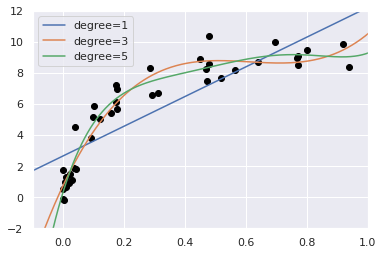

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

The degree of the polynomial is what controls the complexity of the model in this case. The question we want to answer is: what degree of polynomial provides a suitable trade-off between bias (under-fitting) and variance (over-fitting).

We can visualize the validation curve for this particular data and model using the `validation_curve` convenience routine provided by Scikit-Learn. Given a model, data, parameter name, and a range to explore, this function will automatically compute both the training score and validation score across the range:

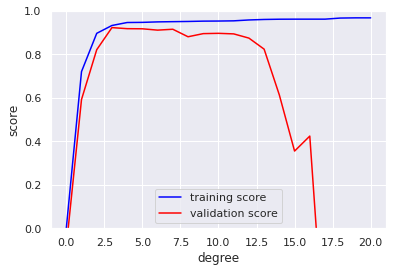

In [13]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

From the validation curve, we can see that the optimal trade-off between bias and variance is found for a third-order polynomial. We can compute and display this fit over the original data as follows:

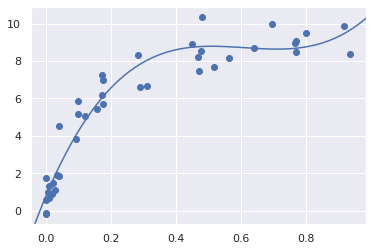

In [14]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

Notice that finding the optimal model did not require us to compute the training score, but examining the relationship between the training score and validation score can give us useful insight into the performance of the model.

## Learning Curves

The optimal model will generally depend on the size of the training data. For example, let's generate a new dataset with five times as much points:

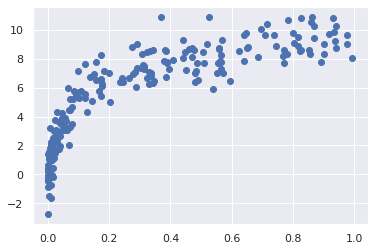

In [15]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

We will duplicate the preceding code to plot the validation curve for this larger dataset, as well as the previous results for reference:

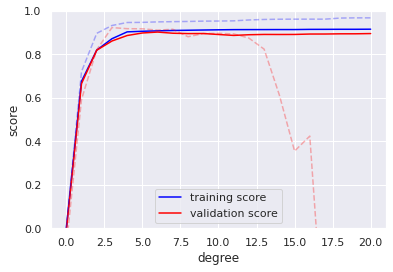

In [16]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

The solid lines show the new results, while the fainter dashed lines show the results of the previous smaller dataset. It is evident that the new dataset can support much more complicated models: even a degree-20 model is not seriously over-fitting the data: the validation and training scores remain very close.

Thus we see that the behavior of the validation curve has two important inputs: the model complexity and the number of training points. It is often useful to explore the behavior of the model as a function of the number of training points. A plot of the training/validation score with respect to the size of the training set is known as a _learning curve_.

The general behavior we can expect from a learning curve is this:

- A model of a given complexity will _overfit_ a small dataset: this means that the training score will be relatively high, while the validation score will be relatively low.
- A model of a given complexity will _underfit_ a large dataset: this means that the training score will decrease, but the validation score will increase.
- A model will never (except by chance) give a better score to the validation set than the training set: this means that the curves should keep getting closer together but never cross.

With these features in mind, we can expect a learning curve to look like this:

![Learning Curve Schematic](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-learning-curve.png)

The learning curve converges to a particular score as the number of training samples grow. Once there is enough points that a particular model has converged, _adding more training data will not help!_. The only way to increase model performance in this case would be to use another (often more complex) model.

### Learning curves in Scikit-Learn

Scikit-Learn offers a convenient utility for computing such learning curves. Here we will compute a learning curve for our original dataset with a second-order polynomial model and a ninth-order polynomial:

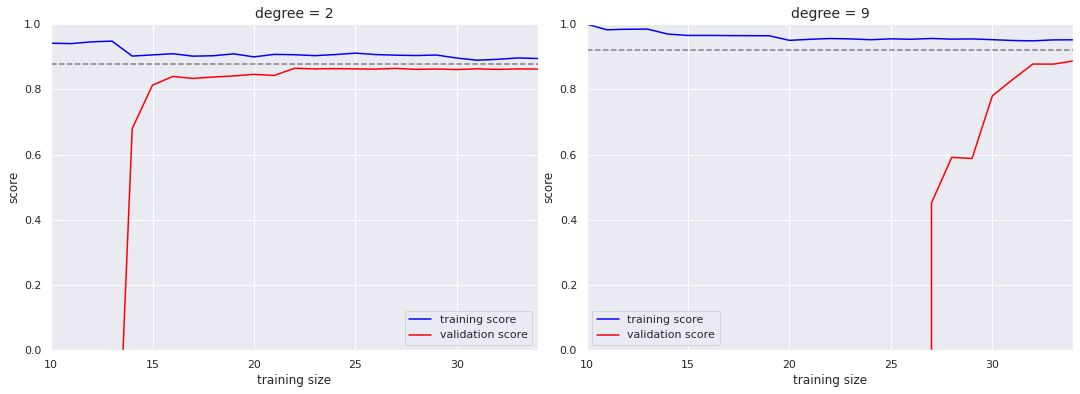

In [17]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

This gives as a valuable visual depiction of how the model responds to increasing the amount of training data. When the learning curve has converged (i.e., when the training and validation curves are already close to each other) _adding more training data will not significantly improve the fit!_. We can verify this with the learning curve for the degree-2 model.

We can see that using a different more complicated model indeed increases the converged score, but at the expense of much higher variance (indicated by the difference between the training and validation scores). If we were to add more data points, the learning curve for the more complicated model would eventually converge.

## Validation in Practice: Grid Search

This purpose of this discussion is meant to give some intuition into the trade-off between bias and variance, and its dependence on model complexity and training set size. In practice, models generally have more than one knob to turn, and thus plots of validation and learning curves change from lines to multi-dimensional surfaces. In such cases, visualization are difficult and we would rather simply find the particular model that maximized the validation score.

Scikit-Learn provides automated tools to do this in the grid search module. In this example of using grid search to find the optimal polynomial model, we will explore a three-dimensional grid of model features: the polynomial degree, the flag telling us whether to fit the intercept, and the flag telling us whether to normalize the problem. We can set this up using the `GridSearchCV` meta-estimator:

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

Just like a normal estimator, this has not yet been applied to any data. Calling the `fit()` method will fit the model at each grid point, keeping track of the scores along the way:

In [19]:
grid.fit(X, y);

Now that this is fit, we can as for the best parameters:

In [20]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

Finally, we can use the best model and show the fit to our data using code from before:

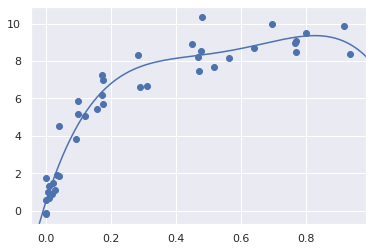

In [21]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

The grid search provided many more options, such as the ability to use a custom scoring function, to parallelize the computations, to do randomized searches, and more.